Numerical electronic structure hands-on
=======================================

**Purpose**:

To understand how numerical electronic structure methods work at the level of writing your own code.

**This notebook**:

1. Second quantization and tight-binding
2. Hilbert space, bosons and fermions
3. The exact diagonalization

**Other topics**:

- *Numerical atomic basis sets*
- *The Hartree-Fock method*
- *Fermionic perturbation theories and other quantum chemistry methods*
  - *Embedding methods*
  - *Green's function methods*
- *Tensor network representations and methods*
- *Density functional theory*
- *Stochastic methods*

*italic* = planned

Purpose of this
---------------

To show how many-body Hamiltonians and their components are constructed and (exact-)diagonalized.

> **Note**: The code presented here is not optimized in any way. The exact diagonalization in literature usually referes to iterative methods for solving implicit Hamiltonians and finding their few low-lying states by employing various symmetries. Those methods serve the same purpose in a different (more involved) way.

The tight-binding Hamiltonian
-----------------------------

$$ H = \sum\limits_{i} t \cdot a^\dagger_{i} a_{i+1} + \mathrm{H.c.} $$

- mean-field: describes non-interacting systems (lattices)
- driven by kinetic energy (hopping)
- the starting point for other electronic Hamiltonians (Hubbard, first-principles)
- straightforward numeric representation

**What does its matrix look like?**

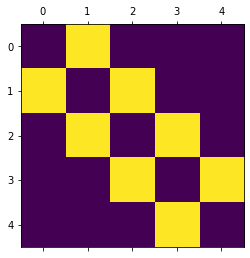

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot

def a__a(N, i, j):
    """The a†_i a_j term in N-space"""
    result = numpy.zeros((N, N), dtype=float)
    result[i, j] = 1
    return result

def tight_binding_hamiltonian(N, t=1):
    """Finite uniform nearest-neighbours Hamiltonian in N-space (free particles hopping on a chain)"""
    result = numpy.eye(N, k=1, dtype=float)
    result *= t
    result += result.conj().T
    return result

N = 5
pyplot.matshow(tight_binding_hamiltonian(N))

**What is the matrix representation of $a^\dagger_i a_{i+1}$?**

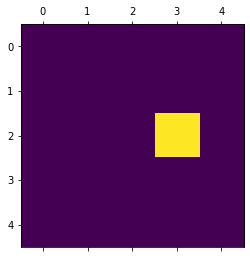

In [2]:
pyplot.matshow(a__a(N, 2, 3))

This is not the entire **answer**, however.
For example, there is no way to represent non-particle-conserving operators like $a^\dagger_i$ as an entry in this `5x5` matrix.
To understand what's happening let's go back to the definition.

Second quantization
-------------------

Fermions:

 - $\left | \right >$ - vacuum
 - $\left | i \right > = a^\dagger_i \left | \right >$ - single-particle state
 - $\left | j,i \right > = a^\dagger_j a^\dagger_i \left | \right >$ - two-particle state
 - $\left | j,i \right > = - \left | i,j \right >$ - anticommutation
 - $\left | i,i \right > = 0$ - exclusion

Generic (basis) state with a finite number of occupied sites $i, j, k, l, ...$:

$$ \left | i, j, k, l, ... \right > $$

**Let's encode basis states into binary strings:**

```
|i, j, k, l, ...> = (phase) |0, 0, 1, 0, 1, 1, 0, 1, ...>
                                   ^     ^  ^     ^
                                   |     |  |     |
                                   k     i  j     l
```
Let N be the size of the space (= the maximal number of particles our model may handle).
Then,

```
  "00000000" - vacuum, a single basis state (comb(N, 0) = 1)
  "00000001", "00000010", "00000100", ... - one-particle (1p) states: comb(N, 1) = N states
  "00000011", "00000101", "00000110", ... - two-particle (2p) states: comb(N, 2) = (N * (N+1)) / 2 states
  ...
  _____________
  total: comb(N, 0) + comb(N, 1) + ... + comb(N, N) = 2^N - exponentially large
```

> **Note:** The size of the second quantization space is **exponentially large**. This is the (only) reason for exact diagonalization methods and for the many-body electron problem to be **very hard**.

Let's check the sum above:

In [3]:
from scipy.special import comb
sum(comb(N, i) for i in range(N+1)), 2**N

(32.0, 32)

**So why the tight-binding Hamiltonian is a `5x5` matrix rather than `32x32`?**

**Answer:** only a submatrix of the Hamiltonian is written in the single-particle basis.

```
    |    x          | < 00001
    | x     x       | < 00010
H = |    x     x    | < 00100;
    |       x     x | < 01000
    |          x    | < 10000
      ^  ^  ^  ^  ^
      0  0  0  0  1
      0  0  0  1  0
      0  0  1  0  0
      0  1  0  0  0
      1  0  0  0  0
```

Same can be done for $a^\dagger_3 \cdot a_2$ for example:

```
           |               |
           |               |
a†_3 a_2 = |          x----| < 00100;
           |          |    |
           |          |    |
                      ^
                      0
                      0
                      0
                      1
                      0
```

However, single-particle basis set (and any other basis sets with **constant** particle number) does not make any sense for $a^\dagger_3$ which **changes** the particle number.
I.e. the corresponding `5x5` matrices of **both** $a^\dagger_3$ and $a_2$ are zero which countradicts the non-zero **scalar** product $a^\dagger_3 \cdot a_2$.

> **Note**: The tight-binding Hamiltonian matrix is a submatrix of the **actual Hamiltonian** matrix. It enables solving the **actual Hamiltonian** by obtatining **single-particle wavefunctions** and combining them (implicitly) into a Fock product or a Slater determinant, depending whether particles commute or anti-commute. No approximation is made in this case because particles **do not interact**. The proof of this in the matrix language is simple but not straightforward.

Before looking into the **actual Hamiltonian** matrix (=many-body Hamiltonian matrix) let's explore basis states.

First, lets **number** basis states.

```
"00000" = #0 - vacuum
"00001" = #1
"00010" = #2
"00011" = #3
...
"11110" = #30
"11111" = #31 - fully occupied state
```

- The numbering choice is just **permutation** of rows and columns in the final Hamiltonian matrix (i.e. does not affect any physics).
- The choice above is **straightforward** because strings exactly correspond to the index of the basis state written in the basis of $2$: $5_{10} = 101_{2} = 00101_{2}$ ($N=5$ for these examples)
- The numbering chioce, however, also has its **disadvantages**. For example, states with different particle numbers are getting mixed preventing exploration of the block-diagonal structure of particle-conserving Hamiltonians.

The vacuum
----------

In [4]:
vacuum = numpy.zeros(2**N, dtype=float) # state with zero norm
vacuum[0b00000] = 1 # set the desired amplitude by using the above many-body basis numbering
vacuum # properly normalized vacuum state

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
def vacuum(N):
    """Normalized N-particle vacuum state"""
    result = numpy.zeros(2**N, dtype=float)
    s = "0" * N
    index = int(s, 2) # < Basis states numbering is done here
    result[index] = 1
    return result

vacuum(N) # same thing

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Let's now generalize the convertsion of binary strings into vectors.

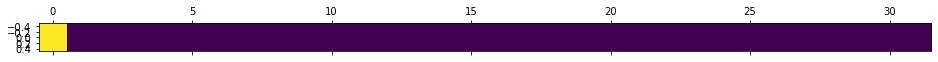

In [6]:
def state(s):
    """Normalized N-particle basis state from a given binary string"""
    result = numpy.zeros(2**len(s), dtype=float)
    index = int(s, 2) # < Basis states numbering is done here
    result[index] = 1
    return result

def vacuum(N):
    """Normalized N-particle vacuum state (redefined but equivalent)"""
    return state("0" * N)

def plot_row(x):
    """Plotting vectors"""
    pyplot.matshow(x[numpy.newaxis, :].real)
    
plot_row(vacuum(N)) # same thing plotted

Single-particle states
----------------------

Single-particle basis states ... have a single particle at $N$ different sites.

**How do they look like?**

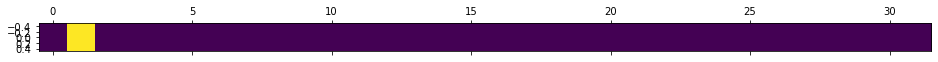

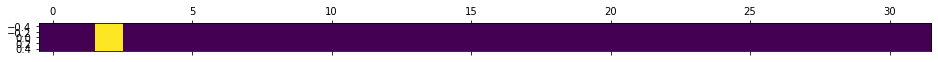

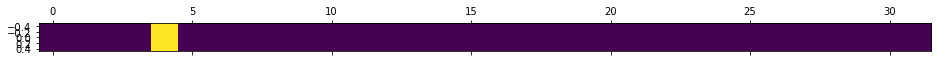

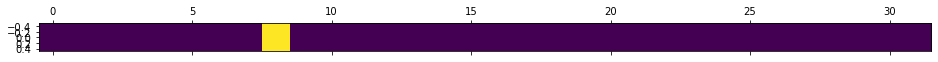

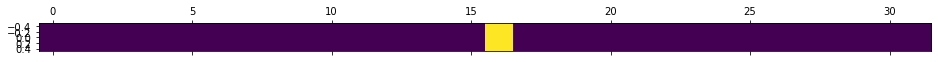

In [7]:
plot_row(state("00001"))
plot_row(state("00010"))
plot_row(state("00100"))
plot_row(state("01000"))
plot_row(state("10000"))

Multi-particle states
---------------------

> **Note:** Two-particle states **do not set two amplitudes**. They set **one specific amplitude** corresponing to two specific sites occupied. This is the essence of second quantization.

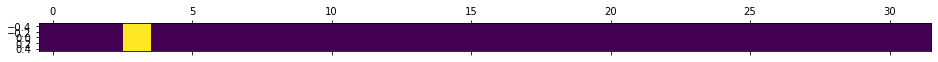

In [8]:
plot_row(state("00011"))

**What are all 32 basis states here?**

In [9]:
import itertools

def strings_iter(N):
    """Iterates over binary strings representing many-body basis states of the N-space"""
    return map("".join, itertools.product(*(("01",) * N)))

for _, i in enumerate(strings_iter(N)):
    print('"{}" = #{:d}'.format(i, _))

"00000" = #0
"00001" = #1
"00010" = #2
"00011" = #3
"00100" = #4
"00101" = #5
"00110" = #6
"00111" = #7
"01000" = #8
"01001" = #9
"01010" = #10
"01011" = #11
"01100" = #12
"01101" = #13
"01110" = #14
"01111" = #15
"10000" = #16
"10001" = #17
"10010" = #18
"10011" = #19
"10100" = #20
"10101" = #21
"10110" = #22
"10111" = #23
"11000" = #24
"11001" = #25
"11010" = #26
"11011" = #27
"11100" = #28
"11101" = #29
"11110" = #30
"11111" = #31


As mentioned, states with the same number of particles are scattered across the basis, let's see it:

In [10]:
lookup = {v: k for k, v in enumerate(strings_iter(N))} # the lookup table for basis states

def strings_iter(N, m=None):
    """Iterates over binary strings representing many-body basis states of the N-space with m particles"""
    return filter(lambda x: m is None or x.count("1") == m, map("".join, itertools.product(*(("01",) * N))))

for i in strings_iter(N, 2):
    print('"{}" = #{:d}'.format(i, lookup[i]))

"00011" = #3
"00101" = #5
"00110" = #6
"01001" = #9
"01010" = #10
"01100" = #12
"10001" = #17
"10010" = #18
"10100" = #20
"11000" = #24


This is how it looks on the index scale:

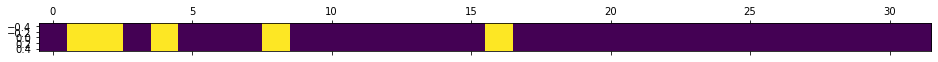

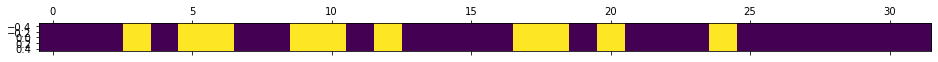

In [11]:
plot_row(sum(map(state, strings_iter(N, 1)))) # 1p states mask
plot_row(sum(map(state, strings_iter(N, 2)))) # 2p states mask

Anticommutation
---------------

- Basis states are obtained from vacuum by applying on-site particle creation operators $a^\dagger_i$.
- The **same** basis state can be obtained in a multitude of different ways, depending on the order of the operators applied.
- If $a^\dagger_i$ do not commute (fermions) a phase is picked in front of the state.
- The phase is defined with respect to some **reference** state obtained through **specifically ordered** $a^\dagger_i$.
- The easiest choice here is to select zero phase for the sorted operator order, from $a^\dagger_i$ with a smallest $i$ to the one with the largest $i$.
- For fermions, the possible phases are only $0$ and $\pi$ which interchange into each other when neighboring operators swap.

$$ \left | 2, 3 \right > = - \left | 3, 2 \right > \sim \mathrm{00110_2} $$

The fermion anticommutation sign is obtained by counting the number of permutations required to achieve the reference operator order (sorted in this case). **Let's make sure we understand how it works**:

In [12]:
def fermion_sign(args):
    """Retrieves the fermion sign by ordering operator indexes. Assumes all indexes are different"""
    result = 0
    for _i, i in enumerate(args):
        for j in args[:_i]:
            result += i < j
    return (-1) ** result

print(fermion_sign((0, 1, 2)), fermion_sign((3, 1, 0))) # 310 -> 301 -> 031 -> 013 (3 permutations)

1 -1


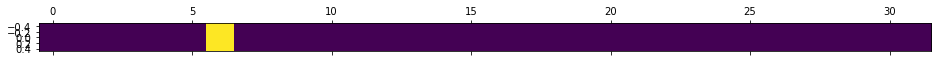

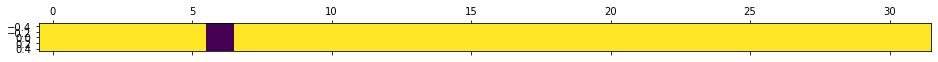

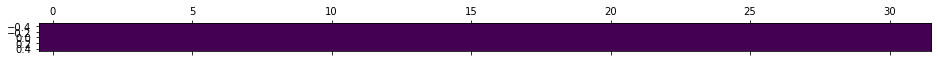

In [13]:
def fermion_state(N, args):
    """Fermions basis state with a sign: the result of a product of a†_args[0] · a†_args[1] · a†_args[2] · ... · |vacuum>"""
    if len(set(args)) != len(args):
        return numpy.zeros(2**N, dtype=float)
    s = "".join("1" if i in args else "0" for i in range(N))
    return fermion_sign(args) * state(s)

plot_row(fermion_state(N, (2, 3))) # basis state
plot_row(fermion_state(N, (3, 2))) # same state with a negative sign
plot_row(fermion_state(N, (2, 2))) # cannot occupy the same site twice -> zero-norm state

Spins (or hard core bosons) are simpler: operators there **do** commute so no order tracking is necessary.

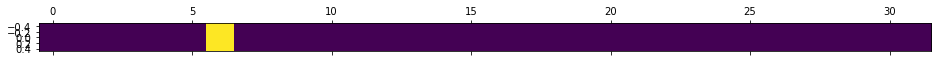

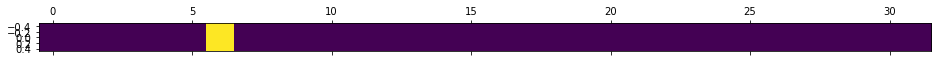

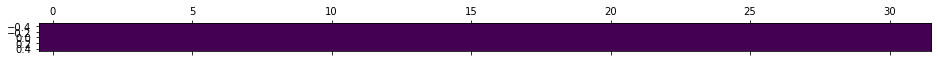

In [14]:
def spin_state(N, args):
    """Spin basis state: the result of a product of a†_args[0] · a†_args[1] · a†_args[2] · ... · |vacuum>"""
    if len(set(args)) != len(args):
        return numpy.zeros(2**N, dtype=float)
    s = "".join("1" if i in args else "0" for i in range(N))
    return state(s)

plot_row(spin_state(N, (2, 3))) # |2, 3>
plot_row(spin_state(N, (3, 2))) # |3, 2>
plot_row(spin_state(N, (2, 2))) # |2, 2> = 0 (the double occupation is prohibited)

- The purpose of the above is to demonstrate several equivalent choices that can be made when making basis states.
- It does not help to define operators as a matrix, though.
- To do this, one needs to make a **step back** and to see **how one-site basis functions are transformed into many-site ones**.
- This is as simple as joining wavefunctions by the Kronecker (direct) product.

Joining particle spaces
-----------------------

At the binary string level of representing basis states we would like to do the following:

```
"100" joins with "01" = "10001"
 ^^^              ^^     ^^^^^
space 2        space 1  space 2&1
```

- "01" means a particle sitting on the site 0 of the first space with 2 sites - one of the basis states of the first space;
- "100" means a particle sitting on the site 2 of the second space with 3 sites - one of the basis states of the second space;
- "10001" means two particles sitting on sites 0 and 4 of a space with 5 sites. It is also the basis state of the corresponfing space

> **Note**: A Big Endian notation is used for both binary strings and space order. Again, this is an arbitrary choice (and the default one).

In the bra-ket notation, the expression is the following:

$ \left | 0 \right >_2 \times \left | 2 \right >_3 = \left | 0, 4 \right >_5 ~.$

**What joining spaces looks like at the vector level?**

**Answer**: as simple as the direct product $ a_i \times b_j = (a \cdot b)_{(ij)} $ reshaped into a vector.
$(ij)$ means a joint index (first runs columns, then rows which is yet-another-arbitrary default choice).

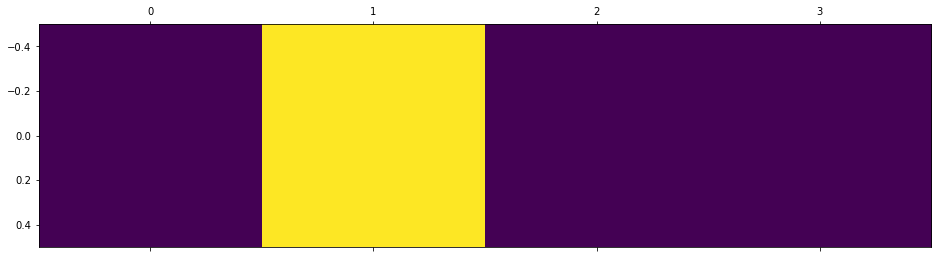

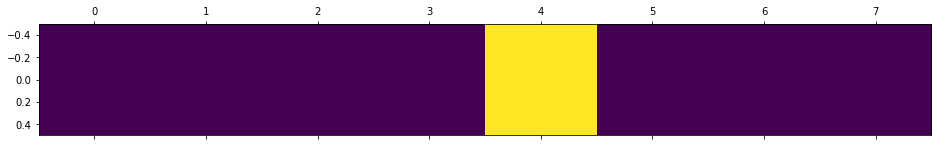

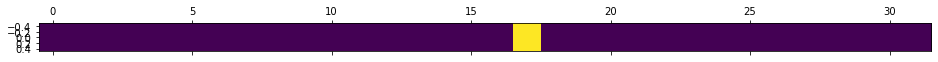

In [15]:
a = state("01")
b = state("100")
ab = numpy.kron(b, a) # fortunately, there is alreasy a function for direct products
plot_row(a) # length 2^2 = 4
plot_row(b) # length 2^3 = 8
plot_row(ab) # length 4*8 = 32, single amplitude set

In [16]:
print("{:05b}".format(int(numpy.where(ab)[0]))) # prints the non-zero amplitude

10001


- The final ingredient before proceeding further is a formal definition of the $N=1$ or the *on-site* basis.
- It is usually the Pauli basis with two basis functions (occupied or free, spin-up or spin-down, 0 or 1) and four basis matrices ($1, ~\sigma_x, ~\sigma_y, ~\sigma_z$).
- Sometimes, the basis is larger (for example, spin-1 basis or hard spinful bosons and fermions). These choices, however, can **always** be interpreted as Pauli matrices where *some* basis states are discarded.

Pauli basis
-----------

In [17]:
one, sx, sy, sz = map(numpy.array, (
    [
        [1, 0],
        [0, 1]
    ], [
        [0, 1],
        [1, 0]
    ], [
        [0, 1.j],
        [-1.j, 0]
    ], [
        [1, 0],
        [0, -1]
    ])) # the basis

Two important derivative operators:
- the raising operator $a^\dagger = \sigma^+ = \left ( \sigma_x + i \sigma_y \right ) / 2 = \left | 1 \right > \left < 0 \right |$
- the lowering operator $a = \sigma^- = \left ( \sigma_x - i \sigma_y \right ) / 2 = \left | 0 \right > \left < 1 \right |$

**What do they look like?**

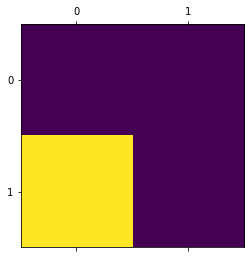

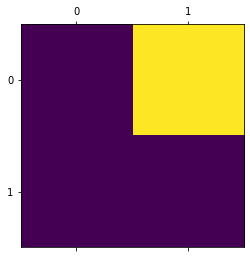

In [18]:
sp, sm = (sx + 1.j*sy).real / 2, (sx - 1.j*sy).real / 2
pyplot.matshow(sp)
pyplot.matshow(sm)

**How do they act on vacuum?**

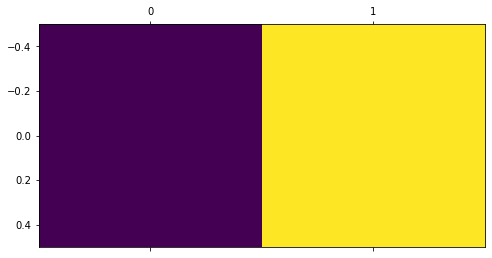

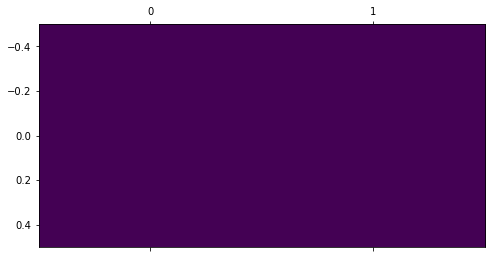

In [19]:
plot_row(sp @ vacuum(1)) # "create a particle in the vacuum": this should produce a 1p state
plot_row(sm @ vacuum(1)) # "destroy a particle in the vacuum"

On-site second quantization basis
---------------------------------

- The `vacuum(1)` is one of the basis states of Pauli matrices (named "spin-down", "vacuum", "free", "zero", ... depending on the context).
- `sp @ vacuum(1)` is the other one (named "spin-up", "particle", "occupied", "one", ... depending on the context).

**Let's look into them.**

In [20]:
s_zero = vacuum(1)
s_one = sp @ s_zero
print(s_zero, s_one)

[1. 0.] [0. 1.]


**Let's now check the definition of $a^\dagger$, $a$ ...**

In [21]:
print(sp @ s_zero, numpy.all(sp @ s_zero == s_one)) # a† · |vac> = |1>
print(sm @ s_one, numpy.all(sm @ s_one == s_zero)) # a · |1> = |vac>

print(sp @ s_one, numpy.all(sp @ s_one) == 0) # a† · |1> = 0
print(sm @ s_zero, numpy.all(sm @ s_zero) == 0) # a · |vac> = 0

[0. 1.] True
[1. 0.] True
[0. 0.] True
[0. 0.] True


**... and the action of $1$, $\sigma_z$ on the on-site basis**

In [22]:
print(one @ s_zero, numpy.all(one @ s_zero == s_zero)) # 1 · |vac> = |vac>
print(one @ s_one, numpy.all(one @ s_one == s_one)) # 1 · |1> = |1>

print(sz @ s_zero, numpy.all(sz @ s_zero == s_zero)) # sz · |vac> = |vac>
print(sz @ s_one, numpy.all(sz @ s_one == -s_one)) # sz · |1> = - |1>

[1. 0.] True
[0. 1.] True
[1. 0.] True
[ 0. -1.] True


> **Note**: Similarly to ($1, ~\sigma_x, ~\sigma_y, ~\sigma_z$), the set ($1, ~\sigma^+, ~\sigma^-, ~\sigma_z$) also forms a complete basis set for matrixes. However, the latter is real-valued.

> **Note**: **The minus sign in the last line of the output can and will be used for anti-commutation relations.**

**How to construct the many-body basis using Kronecker product?**

**Answer**: Simple. Just combine all possible on-site basis functions $\left | 0 \right >$, $\left | 1 \right >$ into basis trains $\left | 1 \right > \times \left | 1 \right > \times \left | 0 \right > \times \left | 0 \right > \times ... $ of size $N$ and evaluate the product(s).

> **Note**: This is 100% equivalent to constructing binary strings "0101000..." as done before.

True
True


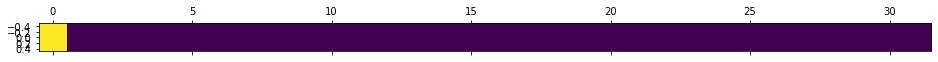

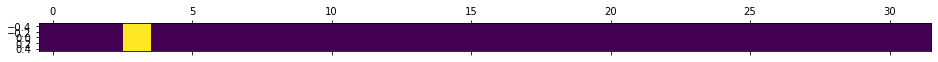

In [23]:
import functools

def _state(s):
    """Constructs a basis state from a binary string."""
    return functools.reduce(numpy.kron, (
        {"0": s_zero, "1": s_one}[i]
        for i in s
    ))

def _vacuum(N):
    """Constructs vacuum."""
    return _state("0" * N)

plot_row(_vacuum(N))
plot_row(_state("00011"))

print(numpy.all(_vacuum(N) == vacuum(N))) # equivalence to the previous implementation
print(numpy.all(_state("00011") == state("00011"))) # equivalence to the previous implementation

Joining particle spaces: operators
----------------------------------

This is the last step before writing out the many-body Hamiltonian matrix.

- Intuitively, $a^\dagger_i$ means "create particle at state 'i' and do nothing elsewhere".
- Particle creation is $a^\dagger = \sigma^+$.
- Doing nothing is unity $1$ (keeps the phase) or $\sigma_z$ (flips the sign).

Finally,

- Kronecker product commutes with the scalar product:

$$ \left ( O_1 \left | ... \right >_1 \right ) \times \left ( O_2 \left | ... \right >_2 \right ) = \left ( O_1 \times O_2 \right ) \left ( \left | ... \right >_1 \times \left | ... \right >_2 \right ) ~ .$$

With $N_1 = N_2 = 1$ (1p spaces), $O_1 = a^\dagger$, $O_2 = 1$ ("do nothing"):

$$ \left ( a^\dagger \left | ... \right >_1 \right ) \times \left ( 1 \left | ... \right >_2 \right ) = \left ( a^\dagger \times 1 \right ) \left ( \left | ... \right >_1 \times \left | ... \right >_2 \right ) ~ .$$

This generalizes to the following operator train, $a^\dagger = \sigma^+$ is a `2x2` matrix:

```
a†_i = 1 x 1 x 1 x ... x a† x 1 x 1 x ... x 1
                         ^
                         i
```

**What does the matrix representation of $a^\dagger_i$ look like?**

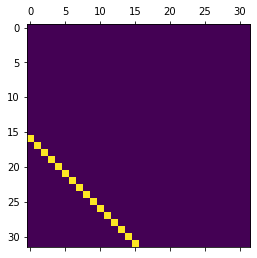

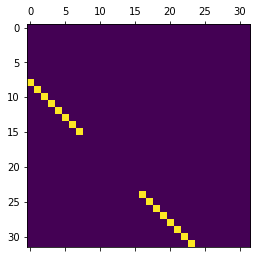

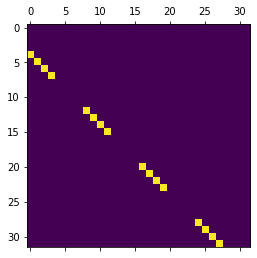

In [24]:
def op_create(N, i):
    """Particle creation at site i in the N-space"""
    return functools.reduce(numpy.kron, (one if _ != i else sp for _ in range(N))) # just return the train evaluated

pyplot.matshow(op_create(N, 0))
pyplot.matshow(op_create(N, 1))
pyplot.matshow(op_create(N, 2))

**Answer**: $a^\dagger_i$ is a sparse matrix with $2^{N-1}$ non-zero entries.

> **Note**:
- Good news: it **is** sparse.
- Bad news: the number of non-zero entries is exponentially large.

**$a_i$ is just transpose and Hermitian conjugate of $a^\dagger_i$. Let's see it.**

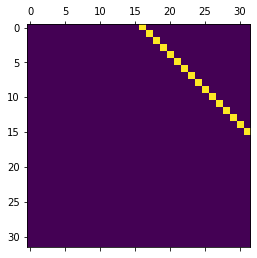

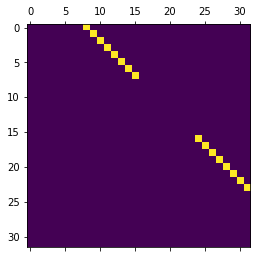

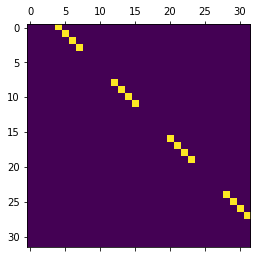

In [25]:
def op_destroy(N, i):
    """Particle destruction at site i in the N-space"""
    return functools.reduce(numpy.kron, (one if _ != i else sm for _ in range(N)))

pyplot.matshow(op_destroy(N, 0))
pyplot.matshow(op_destroy(N, 1))
pyplot.matshow(op_destroy(N, 2))

**With particle creation and annihilation defined, arbitrary operators become available.**

Among them, the on-site particle number operator is just a **scalar product** as it should be.

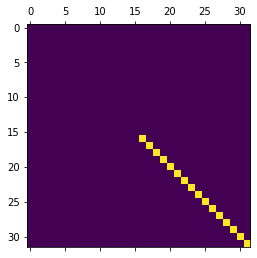

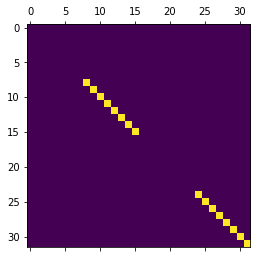

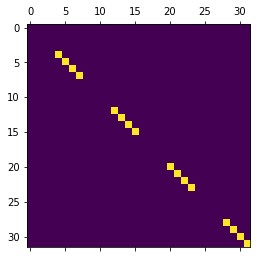

In [26]:
def op_pn(N, i):
    """Particle number at site i in the N-space"""
    return op_create(N, i) @ op_destroy(N, i)

pyplot.matshow(op_pn(N, 0))
pyplot.matshow(op_pn(N, 1))
pyplot.matshow(op_pn(N, 2))

No surprise, it is diagonal in the particle number basis.
Moreover, a **more efficient** way of constructing it (and every other scalar product) is using the same operator train (i.e. taking scalar products first):

$$ a^\dagger_i a_i = \left (1 \cdot 1 \right ) \times \left (1 \cdot 1 \right ) \times ... \times \left (1 \cdot 1 \right ) \times \left (a^\dagger \cdot a \right ) \times \left (1 \cdot 1 \right ) \times ... \times \left (1 \cdot 1 \right ) \times \left (1 \cdot 1 \right ) = 1 \times 1 \times ... \times 1 \times n \times 1 \times ... \times 1 \times 1 ~,$$

where $n = a^\dagger a$ is a `2x2` matrix.

> **Note**: Product train of on-site states and operators is a specific case of a more general "tensor networks" notion which includes matrix product states (MPS) and matrix product operators (MPO), neural networks (NN), diagrams and more. **Contracting multiple tensors efficiently is an open problem.** Not in this specific case, though.

In [27]:
sn = sp @ sm # The particle number
_op_pn = op_pn

def op_pn(N, i):
    """Particle number at site i in the N-space"""
    return functools.reduce(numpy.kron, (one if _ != i else sn for _ in range(N)))

numpy.all(_op_pn(N, 2) == op_pn(N, 2)) # equivalence to the previous implementation

True

The last plot is in obvious way connected to a mask slicing the many-body basis where the second site is occupied:

In [28]:
print("".join(i[2] for i in strings_iter(N))) # Note constant "2" here corresponding to the index n_2 in the particle number operator

00001111000011110000111100001111


Tight-binding chain
-------------------

$$ H = t \sum\limits_i \left ( a^\dagger_i a_{i+1} + a^\dagger_{i+1} a_{i} \right ) $$

The Hamiltonian matrix representation in the many-body basis set is now readily avaiable.

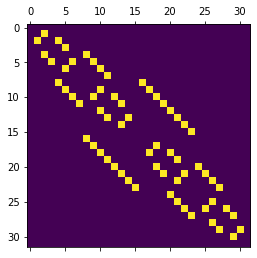

In [29]:
def tight_binding_hamiltonian(N, t=1):
    """Tight-binding nearest-neighbors Hamiltonian in the many-body basis set."""
    return t * sum(op_create(N, i) @ op_destroy(N, i+1) + op_create(N, i+1) @ op_destroy(N, i) for i in range(N-1))

H = tight_binding_hamiltonian(N)
pyplot.matshow(H)

Compared to the `5x5` matrix in the beginning, this one is `32x32` and includes **all** basis states with **all possible** particle numbers.

**Where is the single-particle submatrix?**

Let's find it.

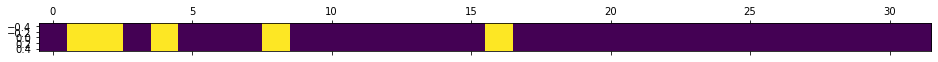

In [30]:
mask_1p = sum(map(state, strings_iter(N, 1))).astype(bool) # mask the 1p space
plot_row(mask_1p)

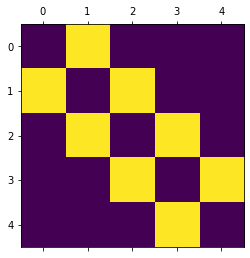

In [31]:
H_1p = H[mask_1p, :][:, mask_1p] # apply the mask to both rows and columns
pyplot.matshow(H_1p)

Bingo!

**Let's now permute the original Hamiltonian into particle-number blocks.**

[ 0  1  2  4  8 16  3  5  6  9 10 12 17 18 20 24  7 11 13 14 19 21 22 25
 26 28 15 23 27 29 30 31]


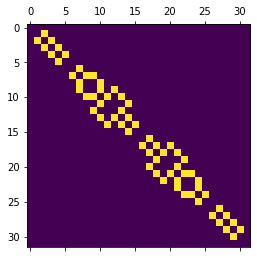

In [32]:
order = numpy.concatenate(tuple(
    numpy.where(sum(map(state, strings_iter(N, i))))[0]
    for i in range(N+1)
))
print(order) # Now the order of basis states follows the number of particles in these states

H_pno = H[order, :][:, order]
pyplot.matshow(H_pno)

4 decoupled matrix blocks are visible in the above which can be diagonalized separately (6 by fact: **vacuum** and **fully-occupied** states are isolated from everythin else).

> **Note**: the exact diagonalization of particle-number blocks is known as full configuration interaction (full-CI) in quantum chemistry. The pre-requisite is, of course, the presence of particle conservation in the Hamiltonian which is *usually* the case.

Single-particle energies
------------------------

**What are single-particle energies of the `5x5` Hamiltonian matrix?**

Let's come back and diagonalize the `5x5` tight-binding Hamiltonian matrix.

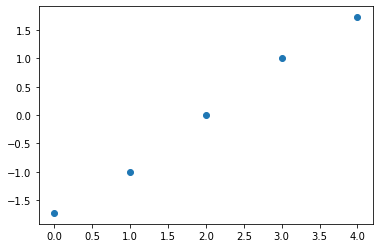

In [33]:
def plot_seq(x):
    """Plots spectra"""
    pyplot.scatter(numpy.arange(len(x)), numpy.array(x).real)

eigs_1p = numpy.array(sorted(numpy.linalg.eigvals(H_1p))) # diagonalize the 1p submatrix
plot_seq(eigs_1p)

**What does the full spectrum from the `32x32` Hamiltonian matrix look like?**

Let's do the same for the `32x32` matrix.

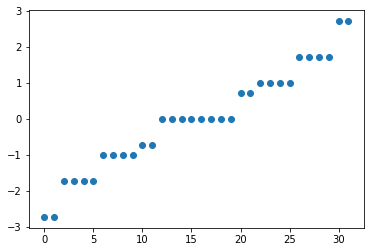

In [34]:
eigs_full = sorted(numpy.linalg.eigvals(H))
plot_seq(eigs_full)

To connect the former to the latter, one just needs to "randomly" occupy single-particle states and to **take all possible sums of single-particle energies**.

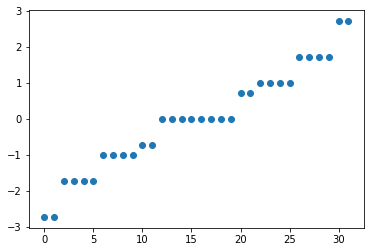

In [35]:
ref_full = tuple(
    eigs_1p[numpy.array(tuple(i)) == "1"].sum()
    for i in strings_iter(N)
)

ref_full = numpy.array(sorted(ref_full))
plot_seq(ref_full)

Perfect match!

The ground state ...
--------------------

... is the lowest-energy eigenstate by defintion.
We have two of those.
The reason is the sole single-particle state at the zero energy.

> **Note**: the zero-energy state is an artifact of the example model.

Thus, when looking at the ground state, two or three particles are expected.

**Let's calculate the number of particles in the ground state.**

First, find and plot the ground state.

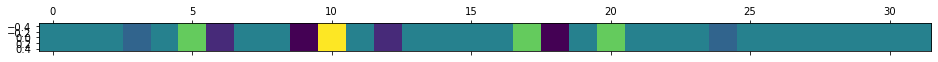

In [36]:
vals, vecs = numpy.linalg.eig(H)
vec = vecs[:, numpy.argmin(vals)]
plot_row(vec)

Then, define the particle **total** number operator.

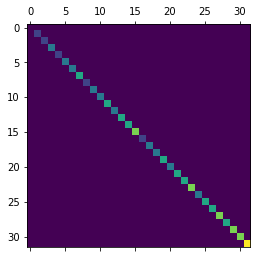

In [37]:
total_number = sum(op_pn(N, i) for i in range(N))

pyplot.matshow(total_number)

Finally, one calculates the bracket.

In [38]:
vec @ total_number @ vec # This was always 2 in my case up to a tiny machine-precision error

(2.0000000000000004+0j)

We calculated the full spectrum of a tight-binding Hamiltonian.

**But was it fermionic or bosonic?**

Fortunately, we can directly check (anti-)commutation relations (a specific case shown).

$$ a^\dagger_0 a_1 - a_1 a^\dagger_0 = ? $$
$$ a^\dagger_0 a_1 + a_1 a^\dagger_0 = ? $$

In [39]:
a0 = op_create(N, 0)
a1 = op_destroy(N, 1)
print(abs(a0 @ a1 - a1 @ a0).max()) # commutation
print(abs(a0 @ a1 + a1 @ a0).max()) # anti-commutation

0.0
2.0


Obviously, our particles bosons.
Let's fix this.

Making the Hamiltonian fermionic
--------------------------------

The boson train results in the following products:

$$ a^\dagger_0 a_1 = \left (a^\dagger \cdot 1 \right ) \times \left (1 \cdot a \right ) \times \left (1 \cdot 1 \right ) \times \left (1 \cdot 1 \right ) \times ... = a^\dagger \times a \times 1 \times ... $$
$$ a_1 a^\dagger_0 = \left (1 \cdot a^\dagger \right ) \times \left (a \cdot 1 \right ) \times \left (1 \cdot 1 \right ) \times \left (1 \cdot 1 \right ) \times ... = a^\dagger \times a \times 1 \times ... $$

Let's define the fermion train:

$$ o_i = 1 \times 1 \times 1 \times ... \times 1 \times o \times \sigma_z \times \sigma_z \times ...$$

And calculate the products:

$$ a^\dagger_0 a_1 = \left (a^\dagger \cdot 1 \right ) \times \left (\sigma_z \cdot a \right ) \times \left (\sigma_z \cdot \sigma_z \right ) \times \left (\sigma_z \cdot \sigma_z \right ) \times ... = + a^\dagger \times a \times 1 \times ... $$
$$ a_1 a^\dagger_0 = \left (1 \cdot a^\dagger \right ) \times \left (a \cdot \sigma_z \right ) \times \left (\sigma_z \cdot \sigma_z \right ) \times \left (\sigma_z \cdot \sigma_z \right ) \times ... = - a^\dagger \times a \times 1 \times ... $$

$$ a^\dagger_1 a_0 = \left (1 \cdot a \right ) \times \left (a^\dagger \cdot \sigma_z \right ) \times \left (\sigma_z \cdot \sigma_z \right ) \times \left (\sigma_z \cdot \sigma_z \right ) \times ... = + a \times a^\dagger \times 1 \times ... $$
$$ a_0 a^\dagger_1 = \left (a \cdot 1 \right ) \times \left ( \sigma_z \cdot a^\dagger \right ) \times \left (\sigma_z \cdot \sigma_z \right ) \times \left (\sigma_z \cdot \sigma_z \right ) \times ... = - a \times a^\dagger \times 1 \times ... $$

Because

$$ \sigma_z \cdot a = a ~,$$
$$ a \cdot \sigma_z = -a ~,$$
$$ \sigma_z \cdot a^\dagger = -a^\dagger ~,$$
$$ a^\dagger \cdot \sigma_z = a^\dagger ~.$$

> **Note**: it is easy to see that $\sigma_z$ and $1$ can be swapped with each other without losing commutation relations. **In both cases.** I.e. choosing $\sigma_z$ to do the "fermion magic" or unity is yet another arbitrary choice to make.

**Let's check the signs in the above equations**:

In [40]:
print(sz @ sm, numpy.all(sz @ sm == +sm))
print(sm @ sz, numpy.all(sm @ sz == -sm))

print(sz @ sp, numpy.all(sz @ sp == -sp))
print(sp @ sz, numpy.all(sp @ sz == +sp))

[[0. 1.]
 [0. 0.]] True
[[ 0. -1.]
 [ 0.  0.]] True
[[ 0.  0.]
 [-1.  0.]] True
[[0. 0.]
 [1. 0.]] True


And now we are ready to redefine fermion operators.

In [41]:
def op_create(N, i):
    """Particle creation at site i in the N-space"""
    return functools.reduce(numpy.kron, (one if _ < i else sp if _ == i else sz for _ in range(N)))

def op_destroy(N, i):
    """Particle destruction at site i in the N-space"""
    return functools.reduce(numpy.kron, (one if _ < i else sm if _ == i else sz for _ in range(N)))

With these definitions, it is probably a good idea to go back and to see that ... nothing changes.
Neither the `5x5` Hamiltonian matrix, nor the `32x32` matrix has a single matrix element changed.
The reason for that is simple: the anticommutation sign tracks "**normal ordering**" of operators.
However, all tight-binding models are already normal-ordered.

> **Note**: "normal ordering" means that all creation operators are to the right of all annihilation operators. It is one of the key concepts in Fermionic many-body perturbation theories.

Normal ordering can be seen from the following (a copy-paste from the above):

$$ a^\dagger_0 a_1 = + a^\dagger \times a \times 1 \times ... ~,$$
$$ a_1 a^\dagger_0 = - a^\dagger \times a \times 1 \times ... ~,$$

$$ a^\dagger_1 a_0 = + a \times a^\dagger \times 1 \times ... ~,$$
$$ a_0 a^\dagger_1 = - a \times a^\dagger \times 1 \times ... ~,$$

where **only the first and the third terms are actually present in the tight-binding Hamiltonian**.
Both terms come with a positive sign.